In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import random
import math

## Neural Network using Stochastic Gradient Descent

In [2]:
class Neural_Network():
    def __init__(self, NN_structure, alpha, max_iter):
        self.NN_structure = NN_structure
        self.n_layers = len(NN_structure)
        self.alpha = alpha
        self.max_iter = max_iter
    
    # Defind some types of activation functions and its derivatives:
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def linear(self,x):
        return x
    
    def d_linear(self,x):
        return 1

    def relu(self,x):
        return np.maximum(0,x)

    def d_relu(self,x):
        dx = np.where(x <= 0, 0, 1)
        return dx

    def tanh(self,x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def d_tanh(self,x):
        return 1 - self.tanh(x)**2
    
    
    # Initialize weights:
    def init_weights(self, seed):
        np.random.seed(seed)
        self.theta_ = {}
        for L in range(1, self.n_layers):
#             self.theta_['Layer' + str(L+1)] = np.ones((self.NN_structure[L]['n_neurons'], \
#                                                         self.NN_structure[L-1]['n_neurons'] + 1)) * 0.2
            self.theta_['Layer' + str(L+1)] = np.random.randn(self.NN_structure[L]['n_neurons'], \
                                                        self.NN_structure[L-1]['n_neurons'] + 1) * 0.1
        return self.theta_
    

    def add_bias(self, Xi):
        Xi = np.concatenate(([1], Xi))
        return Xi
    
    def copy_column(self, Xi, n):
        Ai = Xi.T
        for _ in range(n-1):
            Ai = np.concatenate((Ai, Xi.T), axis = 1)
        return Ai
    
    def forward_propagation(self, Xi):
        self.z_ = {}
        self.a_ = {}
        self.z_['2'] = np.dot(self.theta_['Layer2'], self.add_bias(Xi).T)
        self.a_['2'] = eval('self.'+self.NN_structure[1]['activ_func'])(self.z_['2'])
        
        for L in range (2, self.n_layers):
            self.a_[str(L)] = self.add_bias(self.a_[str(L)])
            self.z_[str(L+1)] = np.dot(self.theta_['Layer'+str(L+1)],self.a_[str(L)])
            self.a_[str(L+1)] = eval('self.'+self.NN_structure[L]['activ_func'])(self.z_[str(L+1)])
        return self
            
    def fit(self, X, y):    # including training and validation
        self.init_weights(seed = 10)
        self.costs = []
        self.R_sq_record = []
        n_train = math.ceil(0.9 * X.shape[0])
        n_validate = X.shape[0] - n_train
        
        X_train = X[0 : n_train]
        y_train = y[0 : n_train]
        X_validate = X[n_train : X.shape[0]]
        y_validate = y[n_train : X.shape[0]]
        
        self.n_iter = 0
        for _ in range(self.max_iter):
            cost = 0
            for i in range(X_train.shape[0]):
                self.delta = {}
                self.update = {}

                self.forward_propagation(X_train[i])
                self.delta[str(self.n_layers)] = self.a_[str(self.n_layers)] - y_train[i]
                delta_copy = self.copy_column(np.array([self.delta[str(self.n_layers)]]), \
                                              self.NN_structure[self.n_layers-2]['n_neurons'] + 1)

                self.update[str(self.n_layers)] = np.multiply(self.a_[str(self.n_layers-1)], delta_copy)

                cost += ((self.a_[str(self.n_layers)]-y_train[i])**2/2/X_train.shape[0]).sum()
                
                self.a_['1'] = self.add_bias(X_train[i])
                for L in range(self.n_layers-1, 1, -1):
                    theta_back = np.delete(self.theta_['Layer'+str(L+1)], 0, 1)
                    self.delta[str(L)] = np.multiply(np.dot(theta_back.T, self.delta[str(L+1)]), \
                        eval('self.d_' + self.NN_structure[L-1]['activ_func'])(self.z_[str(L)]))
                    delta_copy = self.copy_column(np.array([self.delta[str(L)]]), \
                                              self.NN_structure[L-2]['n_neurons'] + 1)
                    self.update[str(L)] = np.multiply(self.a_[str(L-1)], delta_copy)

                for L in range(2, self.n_layers+1):
#                     if self.optimizer == 'SGD':
                    self.theta_['Layer'+str(L)] -= self.alpha * self.update[str(L)]
#                     if self.optimizer == 'ADAM':
                        
            
            sum_theta_sq = 0
            for L in range(2, self.n_layers + 1):
                sum_theta_sq += np.square(self.theta_['Layer'+str(L)]).sum()
            
            # Validation step:
            SS_res = 0
            for j in range(X_validate.shape[0]):
                self.forward_propagation(X_validate[j])
                error_each_sample = ((self.a_[str(self.n_layers)] - y_validate[j])**2).sum()
                SS_res += error_each_sample
            y_bar = y_validate.mean(0)
            SS_total = ((y_validate - y_bar)**2).sum()
            R_sq = (1 - SS_res/ SS_total)
            if R_sq >= 0.8:
                break
            self.n_iter += 1
            self.R_sq_record.append(R_sq)
            self.costs.append(cost)
        return self

## Import Data & Data Processing

In [3]:
input_data = pd.read_excel('Input_AHM.xlsx')
target = pd.read_excel('Output_AHM.xlsx')
field_data = pd.read_excel('Field_data.xlsx')
y_merge = np.concatenate((target, field_data), axis = 0)
y_merge = np.log(y_merge)

np.random.seed(101)
input_data, target = shuffle(input_data, target)

n_train = math.ceil(0.90 * input_data.shape[0])           # 90% data for training and validation
n_test = input_data.shape[0] - n_train                    # the rest for blind testing

X = input_data.values
y = target.values
y = np.log(y)
field_data = field_data.values

def normalize(X):
    A = X.copy()
    mean = X.mean(axis = 0)
    diff = X.max(axis = 0) - X.min(axis = 0)
    for j in range(0, X.shape[1]):  
        A[:,j] = (X[:,j] - mean[j]) / diff[j]
    return A

X_norm = normalize(X)
y_norm = normalize(y)

# Define ranges of parameters:
bound_min = X_norm.min(axis = 0)
bound_max = X_norm.max(axis = 0)
diff = np.fabs(bound_max - bound_min)
bounds = []
for i in range(bound_min.shape[0]):
    bounds.append((bound_min[i], bound_max[i]))

# Normalize the field oil production:
y_merge_norm = normalize(y_merge)
field_data_norm = y_merge_norm[-1]

# Split the dataset:
X_train = X_norm[0 : n_train]
y_train = y_norm[0 : n_train]
X_test = X_norm[n_train : input_data.shape[0]]
y_test = y_norm[n_train : input_data.shape[0]]

## Regression with Neural Network

In [4]:
# Neural Network Regression:
NN_structure = [{'n_neurons' : 15, 'activ_func' : 'none'},   
                {'n_neurons' : 45, 'activ_func' : 'tanh'},
                {'n_neurons' : 80, 'activ_func' : 'tanh'},
                {'n_neurons' : 50, 'activ_func' : 'linear'}]       

ANN = Neural_Network(NN_structure, alpha = 0.008, max_iter = 700) 

ANN.fit(X_train, y_train)

theta = ANN.theta_

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def forward_propagation(Xi):
    z_ = {}
    a_ = {}
    z_['2'] = np.dot(ANN.theta_['Layer2'], ANN.add_bias(Xi).T)
    a_['2'] = eval(ANN.NN_structure[1]['activ_func'])(z_['2'])

    for L in range (2, ANN.n_layers):
        a_[str(L)] = ANN.add_bias(a_[str(L)])
        z_[str(L+1)] = np.dot(ANN.theta_['Layer'+str(L+1)], a_[str(L)])
        a_[str(L+1)] = eval(ANN.NN_structure[L]['activ_func'])(z_[str(L+1)])
    return a_[str(ANN.n_layers)]    # return output of the forward calculation

## Sampling Technique: Latin Hypercube using Uniform Distribution
## Optimizer: Differential Evolution

In [5]:
class Latin_Hypercube_Uniform():
    def __init__(self, bounds, popsize):
        self.bounds = bounds
        self.popsize = popsize

    def init_population(self):
        n = self.popsize
        dimension = len(bounds)
        bound_min, bound_max = np.transpose(bounds)
    
        lower_bounds = np.array([])
        upper_bounds = np.array([])
        for i in range(dimension):
            lower_bounds = np.array(np.concatenate((lower_bounds, np.arange(bound_min[i], bound_max[i], (bound_max[i]-bound_min[i])/n)), axis = 0))
            upper_bounds = np.array(np.concatenate((upper_bounds, np.arange(bound_min[i]+(bound_max[i]-bound_min[i])/n, \
                                                        bound_max[i]+(bound_max[i]-bound_min[i])/n/2, (bound_max[i]-bound_min[i])/n)), axis = 0))
        a = lower_bounds.shape[0]
        lower_bounds = lower_bounds.reshape(dimension, int(a/dimension))
        upper_bounds = upper_bounds.reshape(dimension, int(a/dimension))

        population = np.zeros((dimension, n))
        for i in range(len(lower_bounds)):
            population[i] = np.random.uniform(low=lower_bounds[i], high=upper_bounds[i], size=[1, n])[0]
        population = population.T

        for k in range(population.shape[1]):
            np.random.shuffle(population[:, k])
        return population

class ANN_forward():
    def __init__(self, NN_structure, theta):
        self.NN_structure = NN_structure
        self.theta = theta
        self.n_layers = len(NN_structure)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def linear(self, x):
        return x

    def relu(self, x):
        return np.maximum(0,x)

    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def add_bias(self, Xi):
        Xi = np.concatenate(([1], Xi))
        return Xi
    
    def forward_propagation(self, Xi):
        z_ = {}
        a_ = {}
        z_['2'] = np.dot(theta['Layer2'], self.add_bias(Xi).T)
        a_['2'] = eval(self.NN_structure[1]['activ_func'])(z_['2'])

        for L in range (2, self.n_layers):
            a_[str(L)] = self.add_bias(a_[str(L)])
            z_[str(L+1)] = np.dot(theta['Layer'+str(L+1)], a_[str(L)])
            a_[str(L+1)] = eval(self.NN_structure[L]['activ_func'])(z_[str(L+1)])
        return a_[str(self.n_layers)]    # return output of the forward calculation
    
    
class DE(object):
    def __init__(self, bounds, popsize, cross_threshold, mutation, target, tol, max_iter):
        self.popsize = popsize
        self.cross_threshold = cross_threshold
        self.mutation = mutation
        self.max_iter = max_iter
        self.target = target
        self.tol = tol
        self.bounds = bounds
        self.dim = len(bounds)
        self.bound_min, self.bound_max = np.transpose(bounds)
        self.diff = np.fabs(self.bound_max - self.bound_min)

    def fitness(self, position):
        global NN_structure, theta, field_data_norm
        ANN = ANN_forward(NN_structure, theta)
        output = ANN.forward_propagation(position)
        return ((field_data_norm - output)**2).sum()/2        
    
    def evolution(self):
        pop = Latin_Hypercube_Uniform(self.bounds, self.popsize).init_population()
        pop_denorm = self.bound_min + pop * self.diff
        all_fitness = np.asarray([self.fitness(ind) for ind in pop_denorm])
        best_index = np.argmin(all_fitness)
        best_ind = pop_denorm[best_index]
        best_fitness = all_fitness[best_index]
        
        self.n_iter = 0
        self.gbest_vector = []
        for _ in range(self.max_iter):
            for i in range(self.popsize):
                
                idx_list = [idx for idx in range(popsize) if idx != i]
                a, b, c = pop[np.random.choice(idx_list, 3, replace = False)]
                mutant = np.clip(a + self.mutation * (b - c), 0, 1)
                
                cross_position = np.random.rand(self.dim) < self.cross_threshold
                if not np.any(cross_position):
                    cross_position[np.random.randint(0, self.dim)] = True
                
                trial = np.where(cross_position, mutant, pop[i])
                trial_denorm = self.bound_min + trial * self.diff
                
                fitness_candidate = self.fitness(trial_denorm)
                if fitness_candidate < all_fitness[i]:
                    pop[i] = trial
                    all_fitness[i] = fitness_candidate
                    
                    if fitness_candidate < all_fitness[best_index]:
                        best_index = i
                        best_ind = trial_denorm
                        best_fitness = self.fitness(best_ind)
            if abs(best_fitness - self.target) < self.tol:
                break
            self.n_iter += 1
            self.best_ind = best_ind
            self.best_fitness = best_fitness 
            self.gbest_vector.append(self.best_fitness)

## Run DE and denormalize the results

The best solution is:  [6.79498361e+01 2.13804902e-01 5.38729961e-02 2.29982465e-01
 6.53392618e-02 2.65919329e+00 5.16597955e+00 6.50582394e+00
 2.55964517e+00 2.47955487e-01 9.09382079e-01 9.97874691e-01
 4.83969257e-02 3.13992584e+00 3.30846374e+00] 

Number of iterations = 200
Objective function = 0.08331313308275998


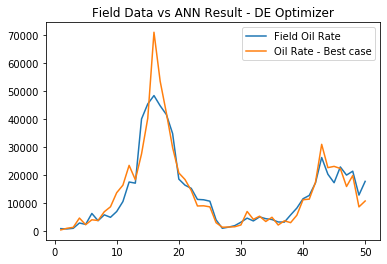

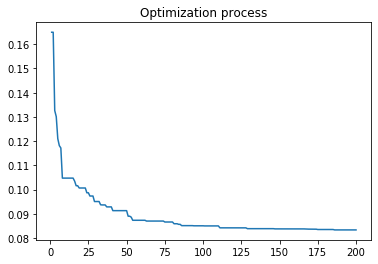

[0.1649675892481477, 0.1649675892481477, 0.13262192693746888, 0.13009646639087402, 0.12099883954297969, 0.11813294768587397, 0.11715593291533354, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10471236253299457, 0.10348505637144598, 0.10157372245682235, 0.10157372245682235, 0.10062875306521898, 0.10062875306521898, 0.10062875306521898, 0.10062875306521898, 0.10062875306521898, 0.09865110681184672, 0.09865110681184672, 0.09731677468260838, 0.09731677468260838, 0.09731677468260838, 0.09504046884119757, 0.09504046884119757, 0.09504046884119757, 0.09504046884119757, 0.09368886261816853, 0.09363163229003368, 0.09363163229003368, 0.09363163229003368, 0.09282461331506194, 0.09282461331506194, 0.09282461331506194, 0.09282461331506194, 0.09127281938242265, 0.09127281938242265, 0.09127281938242265, 0.09127281938242265, 0.09127281938242265, 0.09127281938242265, 0.09127281938242265, 0.091272819382

In [10]:
# Hyper-parameters:
bounds = bounds
popsize = 200
cross_threshold = 0.5
mutation = 0.25
target = 0
tol = 1e-2
max_iter = 200

DE_optimizer = DE(bounds, popsize, cross_threshold, mutation, target, tol, max_iter)
DE_optimizer.evolution()

output = forward_propagation(DE_optimizer.best_ind)

# Denormalize the results:
mean_X = X.mean(axis = 0)
mean_y = y.mean(axis = 0)
diff_X = X.max(axis = 0) - X.min(axis = 0)
diff_y = y.max(axis = 0) - y.min(axis = 0)

def denormalize(X_norm, mean_X, diff_X):
    X_denorm = X_norm.copy()
    for j in range(X_norm.shape[0]):  
        X_denorm[j] = X_norm[j] * diff_X[j] + mean_X[j]
    return X_denorm

y_ANN = denormalize(output, mean_y, diff_y)
y_ANN = np.exp(y_ANN)

# Denormalize the best input set:
best_solution = denormalize(DE_optimizer.best_ind, mean_X, diff_X)

print('The best solution is: ', best_solution, '\n\nNumber of iterations = {}'.format(DE_optimizer.n_iter))
print('Objective function =', DE_optimizer.best_fitness)

# Visualization:
plt.plot(range(1, 51), field_data[0])
plt.plot(range(1, 51), y_ANN)
plt.title('Field Data vs ANN Result - DE Optimizer')
plt.legend(['Field Oil Rate','Oil Rate - Best case'])
plt.show()

# Plot objective function vs. iteration:
plt.plot(range(1, DE_optimizer.n_iter + 1), DE_optimizer.gbest_vector)
plt.title('Optimization process')
plt.show()

print(DE_optimizer.gbest_vector)

In [7]:
# [1.49933225e+02 2.09815550e-01 5.02162120e-02 1.74355544e-01
#  9.57592154e-02 4.02886791e+00 2.82210990e+00 3.24174433e+00
#  1.30642537e+00 2.03403941e-01 5.03513020e-01 9.97874691e-01
#  9.94974470e-02 3.69029412e+00 3.95516097e+00]    #0.10193475001706481

# [1.49933056e+02 2.10191508e-01 5.02162288e-02 1.63392264e-01
#  9.32298953e-02 4.14268394e+00 2.82721145e+00 3.38413361e+00
#  1.15503537e+00 2.03404804e-01 5.03513546e-01 9.97874556e-01
#  9.94974024e-02 3.76853622e+00 4.28761385e+00] # 0.10172

